In [1]:
import sys
import os
import itertools
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

from matplotlib.gridspec import GridSpec
from matplotlib.patches import Patch

sys.path.append(os.path.expanduser('~/Documents/SubSeas'))
from comparison import create_composite

In [2]:
def get_data(npreds: int, std: bool = False):
    """
    Loading data from disk
    """
    name = 'tg-anom_JJA_45r1_31D-roll-mean_q0.5_sep12-15'
    savename = f'/nobackup/users/straaten/interpretation/{name}_{npreds}preds_{"std_" if std else ""}'
    shap_sub = pd.read_hdf(f'{savename}shap_sub.h5', key = 'explanation')
    inpgrad_sub = pd.read_hdf(f'{savename}inpgrad_sub.h5', key = 'explanation')
    outpos = pd.read_hdf(f'{savename}outpos.h5', key = 'values')
    return shap_sub.iloc[:,::-1], inpgrad_sub.iloc[:,::-1], outpos
    
def get_slices(npreds: int):
    """
    Defining interesting slices, based on the data's order in which it is saved.
    """
    if npreds == 4:
        slices = {'west_pacific':slice(1960,nsamples),
                  'soilm_counter':slice(1685,1840),
                  'soilm_driven':slice(0,65)}
    elif npreds == 3:
        slices = {'w_pacif_amplified':slice(25,155),
              'w_pacif_dampened':slice(370,480),
              'w_pacif_negative':slice(1250,1710)}
    else: # == 2
        slices = {'w_pacif_amplified':slice(0,145),
              'w_pacif_dampened':slice(2090,2255),
                'w_pacif_negative':slice(480,1050)}
    return slices

def get_timestamps(sl: slice, data: pd.DataFrame):
    timestamps = data.index[sl].get_level_values('time')
    return timestamps

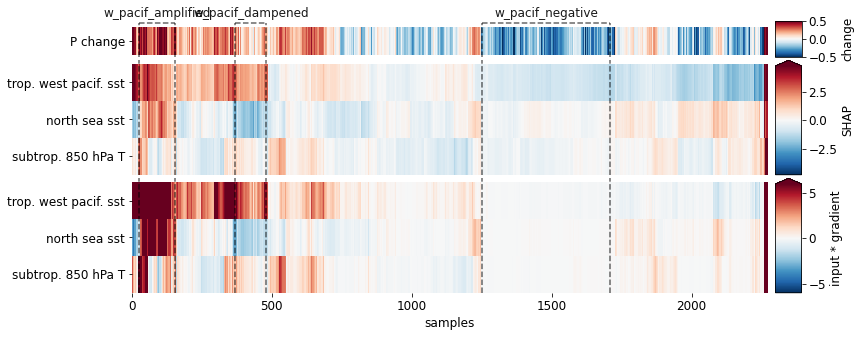

In [23]:
plt.rcParams['font.size'] = 12
npreds = 3
slices = get_slices(npreds)
shap_sub, _, outpos = get_data(npreds = npreds, std = False)
_, inpgrad_sub, _ = get_data(npreds = npreds, std = True)
nsamples = len(shap_sub.index)
order = shap_sub.index
response = 'change'

fig = plt.figure(figsize=(12,5), facecolor = 'white')
gs1 = GridSpec(nrows = (npreds*2)+1, ncols = 20, hspace=0.1, wspace = 0.3)
ax_cor = fig.add_subplot(gs1[:1, :-1])
ax_expl = fig.add_subplot(gs1[1:(npreds+1), :-1])
ax_inpgr = fig.add_subplot(gs1[(npreds+1):, :-1])

ax_cbar_cor = fig.add_subplot(gs1[:1, -1:])
ax_cbar_expl = fig.add_subplot(gs1[1:(npreds+1), -1:])
ax_cbar_inpgr = fig.add_subplot(gs1[(npreds+1):, -1:])

cor = ax_cor.pcolor(outpos[[response]].reindex(order).T.values, vmin = -0.5, vmax = 0.5, cmap = 'RdBu_r')
ax_cor.set_yticks([0.5])
ax_cor.set_yticklabels([f'P {response}'])
ax_cor.xaxis.set_visible(False)

expl = ax_expl.pcolor(shap_sub.reindex(order).T.values, vmin = -4.8, vmax = 4.8, cmap = 'RdBu_r')
ax_expl.set_yticks(np.arange(0.5, len(shap_sub.columns)+0.5,1))
ax_expl.set_yticklabels(shap_sub.columns.to_flat_index().values)
ax_expl.xaxis.set_visible(False)

inpgr = ax_inpgr.pcolor(inpgrad_sub.reindex(order).T.values, vmin = -6, vmax = 6, cmap = 'RdBu_r')
ax_inpgr.set_yticks(np.arange(0.5, len(inpgrad_sub.columns)+0.5,1))
ax_inpgr.set_yticklabels(inpgrad_sub.columns.to_flat_index().values)
ax_inpgr.set_xlabel('samples')

fig.colorbar(cor, cax = ax_cbar_cor, label = response)
fig.colorbar(expl, cax = ax_cbar_expl, label = 'SHAP', extend = 'max')
fig.colorbar(inpgr, cax = ax_cbar_inpgr, label = 'input * gradient',extend = 'max')

for i in ax_expl.spines:
    ax_cor.spines[i].set_visible(False)
    ax_expl.spines[i].set_visible(False)
    ax_inpgr.spines[i].set_visible(False)

expl_height = npreds + 0.1
inpgr_height = expl_height
cor_height = 1.2
color = 'black'
alpha = 0.6
ls = '--'
for key, sl in slices.items():
    ax_expl.vlines(x = max(sl.start,5), color = color, alpha = alpha, ymin = 0, linestyles = ls, ymax = expl_height)
    ax_expl.vlines(x = min(sl.stop,nsamples - 3), color = color, alpha = alpha, ymin = 0, linestyles = ls, ymax = expl_height)
    ax_cor.vlines(x = max(sl.start,5), color = color, alpha = alpha, ymin = -0.1, linestyles = ls, ymax = cor_height)
    ax_cor.vlines(x = min(sl.stop,nsamples - 3), color = color, alpha = alpha, ymin = -0.1, linestyles = ls, ymax = cor_height)
    ax_inpgr.vlines(x = max(sl.start,5), color = color, alpha = alpha, ymin = 0, linestyles = ls, ymax = inpgr_height)
    ax_inpgr.vlines(x = min(sl.stop,nsamples - 3), color = color, alpha = alpha, ymin = 0, linestyles = ls, ymax = inpgr_height)
    ax_cor.hlines(y = cor_height, xmin = sl.start, xmax = sl.stop, color = color, alpha = alpha, linestyles = ls)
    ax_cor.text(x = np.mean([sl.start,sl.stop]), y = cor_height + 0.1, s = key, color = color, alpha = 0.9, verticalalignment = 'bottom', horizontalalignment = 'center')

ax_expl.set_ylim(bottom = 0, top = expl_height)
ax_inpgr.set_ylim(bottom = 0, top = inpgr_height)
ax_cor.set_ylim(bottom = -0.1)
plt.savefig(os.path.expanduser('~/Pictures/shap_annotated.pdf'))
plt.show()

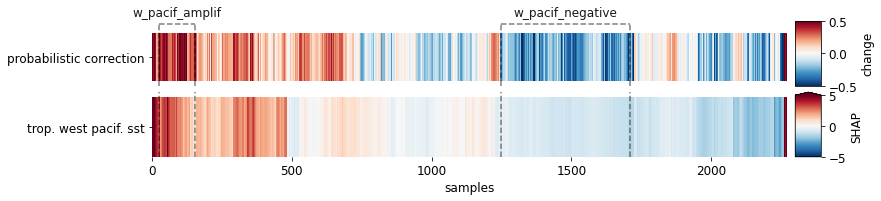

In [9]:
plt.rcParams['font.size'] = 12
npreds = 3
slices = get_slices(npreds)
shap_sub, inpgrad_sub, outpos = get_data(npreds = npreds, std = False)
nsamples = len(shap_sub.index)
order = shap_sub.index
response = 'change'

fig = plt.figure(figsize=(12,2.5), facecolor = 'white')
gs1 = GridSpec(nrows = 2, ncols = 20, hspace=0.1, wspace = 0.3)
ax_expl = fig.add_subplot(gs1[1:, :-1])
ax_cor = fig.add_subplot(gs1[:1, :-1])
ax_cbar_expl = fig.add_subplot(gs1[1:, -1:])
ax_cbar_cor = fig.add_subplot(gs1[:1, -1:])

expl = ax_expl.pcolor(shap_sub.reindex(order).T.values[-1:,:], vmin = -5, vmax = 5, cmap = 'RdBu_r')
ax_expl.set_yticks([0.5])
ax_expl.set_yticklabels(shap_sub.columns.to_flat_index().values[-1:])
ax_expl.set_xlabel('samples')

cor = ax_cor.pcolor(outpos[[response]].reindex(order).T.values, vmin = -0.5, vmax = 0.5, cmap = 'RdBu_r')
ax_cor.set_yticks([0.5])
ax_cor.set_yticklabels([f'probabilistic correction'])
ax_cor.xaxis.set_visible(False)

fig.colorbar(expl, cax = ax_cbar_expl, label = 'SHAP', extend = 'max')
fig.colorbar(cor, cax = ax_cbar_cor, label = response)

for i in ax_expl.spines:
    ax_expl.spines[i].set_visible(False)
    ax_cor.spines[i].set_visible(False)

expl_height = 1 + 0.1
cor_height = 1.2
color = 'black'
alpha = 0.5
ls = '--'
for key, sl in slices.items():
    if not (key == 'w_pacif_damp'):
        ax_expl.vlines(x = max(sl.start,5), color = color, alpha = alpha, ymin = 0, linestyles = ls, ymax = expl_height)
        ax_expl.vlines(x = min(sl.stop,nsamples - 3), color = color, alpha = alpha, ymin = 0, linestyles = ls, ymax = expl_height)
        ax_cor.vlines(x = max(sl.start,5), color = color, alpha = alpha, ymin = -0.1, linestyles = ls, ymax = cor_height)
        ax_cor.vlines(x = min(sl.stop,nsamples - 3), color = color, alpha = alpha, ymin = -0.1, linestyles = ls, ymax = cor_height)
        ax_cor.hlines(y = cor_height, xmin = sl.start, xmax = sl.stop, color = color, alpha = alpha, linestyles = ls)
        ax_cor.text(x = np.mean([sl.start,sl.stop]), y = cor_height + 0.1, s = key, color = color, alpha = 0.9, verticalalignment = 'bottom', horizontalalignment = 'center')

ax_expl.set_ylim(bottom = 0, top = expl_height)
ax_cor.set_ylim(bottom = -0.1)
plt.savefig(os.path.expanduser('~/Pictures/shap_annotated_simpleEGU.pdf'))
plt.show()

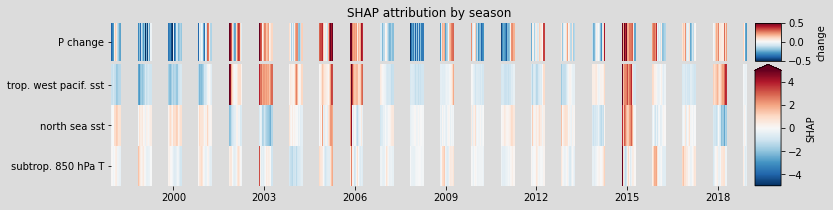

In [17]:
seps = pd.date_range(start = order.get_level_values('time').min(), end = order.get_level_values('time').max(), freq = 'A-SEP')
n_between = 150
gap_index = pd.MultiIndex.from_product([seps, np.arange(16,16+n_between)], names = order.names)
neworder = order.append(gap_index).sort_values()
response = 'change'
#response = 'perc_change'

facecolor = 'gainsboro'

fig = plt.figure(figsize=(12,3), facecolor = facecolor)
gs1 = GridSpec(nrows = npreds+1, ncols = 20, hspace=0.1, wspace = 0.3)
ax_expl = fig.add_subplot(gs1[1:, :-1])
ax_cor = fig.add_subplot(gs1[:1, :-1])
ax_cbar_expl = fig.add_subplot(gs1[1:, -1:])
ax_cbar_cor = fig.add_subplot(gs1[:1, -1:])

cor = ax_cor.pcolor(outpos[[response]].reindex(neworder).T.values, vmin = -0.5, vmax = 0.5, cmap = 'RdBu_r')
ax_cor.set_title('SHAP attribution by season')
ax_cor.set_facecolor(facecolor)
ax_cor.set_yticks([0.5])
ax_cor.set_yticklabels([f'P {response}'])
ax_cor.xaxis.set_visible(False)

expl = ax_expl.pcolor(shap_sub.reindex(neworder).T.values, vmin = -5, vmax = 5, cmap = 'RdBu_r')
ax_expl.set_facecolor(facecolor)
ax_expl.set_yticks(np.arange(0.5, len(inpgrad_sub.columns)+0.5,1))
ax_expl.set_yticklabels(shap_sub.columns.to_flat_index().values)

# Color bars
fig.colorbar(cor, cax = ax_cbar_cor, label = response)
fig.colorbar(expl, cax = ax_cbar_expl,label = 'SHAP', extend = 'max')
ax_cbar_expl.set_facecolor(facecolor)
ax_cbar_cor.set_facecolor(facecolor)

for i in ax_cor.spines:
    ax_cor.spines[i].set_visible(False)
    ax_expl.spines[i].set_visible(False)

# Time axis
stamps = pd.date_range('2000-06-01','2019-06-01', freq = 'A-JUN')[::3]
inds = np.where(neworder.get_level_values('time').map(lambda t: t in stamps).values)[0]
ax_expl.set_xticks(inds)
ax_expl.set_xticklabels(stamps.year)
#plt.savefig(os.path.expanduser('~/Pictures/shap_per_season.pdf'))
plt.show()

## Situation as observed at forecast, observed at initialization, and as forecast at forecast

In [3]:
z_daily = xr.open_dataarray('/nobackup_1/users/straaten/processed/z300_nhnorm.anom.nc')
z_21 = xr.open_dataset('/nobackup_1/users/straaten/processed/z300_nhnorm.21.anom.nc')[z_daily.name]

sst_daily = xr.open_dataarray('/nobackup_1/users/straaten/processed/sst_nhplus.anom.nc')
sst_21 = xr.open_dataset('/nobackup_1/users/straaten/processed/sst_nhplus.21.anom.nc')[sst_daily.name]

swvl13_daily = xr.open_dataarray('/nobackup_1/users/straaten/processed/swvl13_europe.anom.nc')
swvl13_21 = xr.open_dataset('/nobackup_1/users/straaten/processed/swvl13_europe.21.anom.nc')[swvl13_daily.name]

t850_daily = xr.open_dataarray('/nobackup_1/users/straaten/processed/t850_nhblock.anom.nc')
t850_21 = xr.open_dataset('/nobackup_1/users/straaten/processed/t850_nhblock.21.anom.nc')[t850_daily.name]

t2m_daily = xr.open_dataarray('/nobackup_1/users/straaten/processed/t2m_europe.anom.nc')
t2m_31 = xr.open_dataset('/nobackup_1/users/straaten/processed/t2m_europe.31.anom.nc')[t2m_daily.name]

#variables = {'z':z_21,'sst':sst_21,'swvl13':swvl13_21,'t850':t850_21,'t2m':t2m_31}
#colorscales = pd.Series(['RdBu_r','RdBu_r','RdBu','RdBu_r','RdBu_r'], index = variables.keys())
#timeaggs = pd.Series([21,21,21,21,31], index = variables.keys())

#variables = {'z':z_21,'tg':t2m_31}
#colorscales = pd.Series(['RdBu_r','RdBu_r'], index = variables.keys())
#timeaggs = pd.Series([21,31], index = variables.keys())

variables = {'swvl13':swvl13_21,}
colorscales = pd.Series(['RdBu'], index = variables.keys())
timeaggs = pd.Series([21], index = variables.keys())

In [4]:
def data_for_pcolormesh(array, shading:str):
    """Xarray array to usuable things"""
    lats = array.latitude.values # Interpreted as northwest corners (90 is in there)
    lons = array.longitude.values # Interpreted as northwest corners (-180 is in there, 180 not)
    if shading == 'flat':
        lats = np.concatenate([lats[[0]] - np.diff(lats)[0], lats], axis = 0) # Adding the sourthern edge 
        lons = np.concatenate([lons, lons[[-1]] + np.diff(lons)[0]], axis = 0)# Adding the eastern edge (only for flat shating)
    return lons, lats, array.values.squeeze()

In [5]:
## Precomputing composites,
final = []
for npreds in [3]: #[2,3,4]:
    shap_sub, _, _ = get_data(npreds = npreds, std = False)
    separation_max = shap_sub.index.get_level_values('separation').max()
    separation_min = shap_sub.index.get_level_values('separation').min()
    leadtimerange = range(separation_min+1, separation_max+2) # Defined including first day (max = 46)
    slices = get_slices(npreds = npreds)
    for key,sl in slices.items():
        composites = pd.DataFrame(np.nan, index = variables.keys(), 
                                  columns = pd.MultiIndex.from_product([[npreds],[key],['init','obs','forc']],names=['npreds','slice','moment']), 
                                  dtype = object)
        timestamps = get_timestamps(sl = sl, data = shap_sub)
        init_timestamps = shap_sub.index.get_level_values('time') - pd.TimedeltaIndex(shap_sub.index.get_level_values('separation') + 1, unit = 'day')
        init_timestamps = init_timestamps[sl] # This is the day that the model ran, not the first day of the forecast, but roughly last day of the assimilated anomalies
        for variable, array in variables.items():
            first_days = init_timestamps - pd.Timedelta(timeaggs.loc[variable] -1, unit = 'D') # Runday (or last day of assimilated anomalies) - (timeagg -1). (timeagg is variable dependent)
            composites.loc[variable,(npreds,key,'init')] = array.loc[first_days,:,:].mean('time')
            composites.loc[variable,(npreds,key,'obs')] = array.loc[timestamps,:,:].mean('time')
            # Now the model forecast
            if not (variable == 't850'):
                _, model_comp = create_composite(dates = timestamps, variable = variable, leadtimerange = leadtimerange, time_agg = timeaggs.loc[variable])
                composites.loc[variable,(npreds,key,'forc')] = model_comp
        final.append(composites)
final = pd.concat(final, axis = 1)

climatology directly loaded
Starting: 167062
1 of range(13, 17) present in 2003-06-05 00:00:00
2003-06-05 00:00:00 added
1 of range(13, 17) present in 2003-06-06 00:00:00
2003-06-06 00:00:00 added
1 of range(13, 17) present in 2003-06-07 00:00:00
2003-06-07 00:00:00 added
2 of range(13, 17) present in 2003-06-04 00:00:00
2003-06-04 00:00:00 added
1 of range(13, 17) present in 2003-06-03 00:00:00
2003-06-03 00:00:00 added
1 of range(13, 17) present in 2003-06-02 00:00:00
2003-06-02 00:00:00 added
1 of range(13, 17) present in 2003-06-01 00:00:00
2003-06-01 00:00:00 added
1 of range(13, 17) present in 2015-06-08 00:00:00
2015-06-08 00:00:00 added
1 of range(13, 17) present in 2015-06-09 00:00:00
2015-06-09 00:00:00 added
1 of range(13, 17) present in 2015-06-10 00:00:00
2015-06-10 00:00:00 added
2 of range(13, 17) present in 2015-06-11 00:00:00
2015-06-11 00:00:00 added
2 of range(13, 17) present in 2005-08-21 00:00:00
2005-08-21 00:00:00 added
1 of range(13, 17) present in 2005-08-20 00

1 of range(13, 17) present in 2015-08-12 00:00:00
2015-08-12 00:00:00 added
1 of range(13, 17) present in 2015-08-13 00:00:00
2015-08-13 00:00:00 added
2 of range(13, 17) present in 2015-08-14 00:00:00
2015-08-14 00:00:00 added
1 of range(13, 17) present in 2010-06-01 00:00:00
2010-06-01 00:00:00 added
1 of range(13, 17) present in 2010-06-02 00:00:00
2010-06-02 00:00:00 added
1 of range(13, 17) present in 2010-06-03 00:00:00
2010-06-03 00:00:00 added
climatology directly loaded
Starting: 167062
1 of range(13, 17) present in 2018-08-19 00:00:00
2018-08-19 00:00:00 added
2 of range(13, 17) present in 2018-08-21 00:00:00
2018-08-21 00:00:00 added
2 of range(13, 17) present in 2018-08-14 00:00:00
2018-08-14 00:00:00 added
1 of range(13, 17) present in 2018-08-17 00:00:00
2018-08-17 00:00:00 added
1 of range(13, 17) present in 2018-08-15 00:00:00
2018-08-15 00:00:00 added
1 of range(13, 17) present in 2018-08-16 00:00:00
2018-08-16 00:00:00 added
1 of range(13, 17) present in 2006-07-20 00

2 of range(13, 17) present in 2009-07-03 00:00:00
2009-07-03 00:00:00 added
1 of range(13, 17) present in 2009-07-04 00:00:00
2009-07-04 00:00:00 added
1 of range(13, 17) present in 2009-07-05 00:00:00
2009-07-05 00:00:00 added
1 of range(13, 17) present in 2009-07-06 00:00:00
2009-07-06 00:00:00 added
1 of range(13, 17) present in 2013-08-23 00:00:00
2013-08-23 00:00:00 added
1 of range(13, 17) present in 2013-08-24 00:00:00
2013-08-24 00:00:00 added
1 of range(13, 17) present in 2013-08-22 00:00:00
2013-08-22 00:00:00 added
2 of range(13, 17) present in 2013-08-21 00:00:00
2013-08-21 00:00:00 added
1 of range(13, 17) present in 2013-08-18 00:00:00
2013-08-18 00:00:00 added
1 of range(13, 17) present in 2013-08-19 00:00:00
2013-08-19 00:00:00 added
1 of range(13, 17) present in 2013-08-20 00:00:00
2013-08-20 00:00:00 added
2 of range(13, 17) present in 2016-07-10 00:00:00
2016-07-10 00:00:00 added
1 of range(13, 17) present in 2016-07-11 00:00:00
2016-07-11 00:00:00 added
1 of range(1

1 of range(13, 17) present in 2008-06-06 00:00:00
2008-06-06 00:00:00 added
1 of range(13, 17) present in 2008-06-05 00:00:00
2008-06-05 00:00:00 added
2 of range(13, 17) present in 2010-07-10 00:00:00
2010-07-10 00:00:00 added
1 of range(13, 17) present in 2010-07-09 00:00:00
2010-07-09 00:00:00 added
1 of range(13, 17) present in 2010-07-08 00:00:00
2010-07-08 00:00:00 added
1 of range(13, 17) present in 2010-07-07 00:00:00
2010-07-07 00:00:00 added
1 of range(13, 17) present in 2009-06-30 00:00:00
2009-06-30 00:00:00 added
1 of range(13, 17) present in 2009-07-01 00:00:00
2009-07-01 00:00:00 added
1 of range(13, 17) present in 2009-07-02 00:00:00
2009-07-02 00:00:00 added
2 of range(13, 17) present in 2012-06-22 00:00:00
2012-06-22 00:00:00 added
2 of range(13, 17) present in 2012-06-21 00:00:00
2012-06-21 00:00:00 added
2 of range(13, 17) present in 2012-06-20 00:00:00
2012-06-20 00:00:00 added
2 of range(13, 17) present in 2012-06-19 00:00:00
2012-06-19 00:00:00 added
2 of range(1

2 of range(13, 17) present in 2008-07-03 00:00:00
2008-07-03 00:00:00 added
1 of range(13, 17) present in 2008-07-02 00:00:00
2008-07-02 00:00:00 added
1 of range(13, 17) present in 2008-07-01 00:00:00
2008-07-01 00:00:00 added
1 of range(13, 17) present in 2008-06-30 00:00:00
2008-06-30 00:00:00 added
1 of range(13, 17) present in 2010-08-25 00:00:00
2010-08-25 00:00:00 added
1 of range(13, 17) present in 2010-08-26 00:00:00
2010-08-26 00:00:00 added
1 of range(13, 17) present in 2010-08-27 00:00:00
2010-08-27 00:00:00 added
1 of range(13, 17) present in 2010-08-28 00:00:00
2010-08-28 00:00:00 added
1 of range(13, 17) present in 2011-06-01 00:00:00
2011-06-01 00:00:00 added
1 of range(13, 17) present in 2011-06-02 00:00:00
2011-06-02 00:00:00 added
1 of range(13, 17) present in 2011-06-03 00:00:00
2011-06-03 00:00:00 added
2 of range(13, 17) present in 2011-06-04 00:00:00
2011-06-04 00:00:00 added
1 of range(13, 17) present in 2011-07-01 00:00:00
2011-07-01 00:00:00 added
1 of range(1

1 of range(13, 17) present in 2008-07-13 00:00:00
2008-07-13 00:00:00 added
1 of range(13, 17) present in 2008-07-12 00:00:00
2008-07-12 00:00:00 added
1 of range(13, 17) present in 2008-07-11 00:00:00
2008-07-11 00:00:00 added
1 of range(13, 17) present in 2008-07-14 00:00:00
2008-07-14 00:00:00 added
1 of range(13, 17) present in 2008-07-16 00:00:00
2008-07-16 00:00:00 added
1 of range(13, 17) present in 2008-07-15 00:00:00
2008-07-15 00:00:00 added
2 of range(13, 17) present in 2008-07-10 00:00:00
2008-07-10 00:00:00 added
2 of range(13, 17) present in 1999-07-17 00:00:00
1999-07-17 00:00:00 added
1 of range(13, 17) present in 1999-07-18 00:00:00
1999-07-18 00:00:00 added
1 of range(13, 17) present in 1999-07-19 00:00:00
1999-07-19 00:00:00 added
1 of range(13, 17) present in 1999-07-20 00:00:00
1999-07-20 00:00:00 added
1 of range(13, 17) present in 2015-08-25 00:00:00
2015-08-25 00:00:00 added
1 of range(13, 17) present in 2015-08-26 00:00:00
2015-08-26 00:00:00 added
1 of range(1

In [6]:
first_days = init_timestamps - pd.Timedelta(timeaggs.loc[variable] -1, unit = 'D')

In [7]:
array_crs = ccrs.PlateCarree()
proj_crs = ccrs.Robinson() #ccrs.PlateCarree() 
shading = 'nearest'
def plotcomposites(fields: pd.DataFrame, color_quantile: float = 0.99, coastlines: bool = False, limit_domain: bool = True):
    """
    Whether to limit the domain for the quantile computation to region around europe.
    """
    fig, axes = plt.subplots(subplot_kw = {'projection':proj_crs}, 
                             nrows = fields.shape[0], ncols = fields.shape[1], 
                             squeeze = False, figsize = (fields.shape[1]*5,fields.shape[0]*2))
    for i, rowlabel in enumerate(fields.index):
        cmap = colorscales.loc[rowlabel]
        for j, columnlabel in enumerate(fields.columns):
            composite = fields.loc[rowlabel,columnlabel]
            if not (composite is np.nan):
                if limit_domain:
                    color_comp = composite.sortby('latitude').sel(latitude = slice(20,80), longitude = slice(-70,30))
                else:
                    color_comp = composite
                vmax = float(np.abs(color_comp.quantile([(1-color_quantile),color_quantile]).values).max())
                axes[i,j].pcolormesh(*data_for_pcolormesh(composite, shading = shading), zorder = 1, shading = shading, 
                      transform = array_crs, cmap = cmap, vmax = vmax, vmin = -vmax)
                if coastlines:
                    axes[i,j].coastlines(zorder = 2, lw = 1)
            if i == 0:
                axes[i,j].set_title(columnlabel, size = 16)
            if j == 0:
                axes[i,j].set_ylabel(rowlabel)

    return fig, axes

def plotcomposites2(fields: pd.DataFrame, vmaxes: pd.DataFrame, coastlines: bool = False):
    fig, axes = plt.subplots(subplot_kw = {'projection':proj_crs}, 
                             nrows = fields.shape[0], ncols = fields.shape[1], 
                             squeeze = False, figsize = (fields.shape[1]*5,fields.shape[0]*2))
    for i, rowlabel in enumerate(fields.index):
        cmap = colorscales.loc[rowlabel]
        for j, columnlabel in enumerate(fields.columns):
            composite = fields.loc[rowlabel,columnlabel]
            if not (composite is np.nan):
                #composite = composite.sortby('latitude').sel(latitude = slice(20,80), longitude = slice(-70,90))
                vmax = vmaxes.loc[rowlabel,columnlabel]
                axes[i,j].pcolormesh(*data_for_pcolormesh(composite, shading = shading), zorder = 1, shading = shading, 
                      transform = array_crs, cmap = cmap, vmax = vmax, vmin = -vmax)
                if coastlines:
                    axes[i,j].coastlines(zorder = 2, lw = 1)
            if i == 0:
                axes[i,j].set_title(columnlabel, size = 16)
            if j == 0:
                axes[i,j].set_ylabel(rowlabel)

    return fig, axes

In [ ]:
## Visualisation test, single slice, both init and 
npreds = 3
slicename = 'w_pacif_amplif'
fields = final.loc[:,(npreds,slicename,slice(None))]
vmaxes = pd.DataFrame(np.array([[520,520,160],[2.2,2.2,1.2],[0.05,0.05,0.03],[2.6,2.6,1]]),index = fields.index, columns = fields.columns)
#plotcomposites2(fields, vmaxes = vmaxes,coastlines=True)
#plt.show()

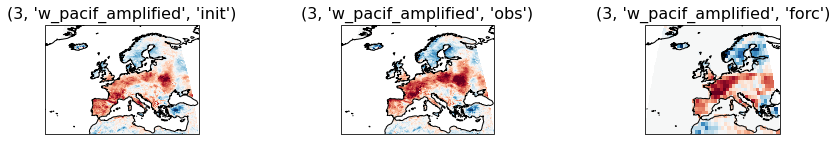

In [37]:
## Visualisation test, single slice, both init and 
npreds = 3
slicename = 'w_pacif_amplified'
fields = final.loc[:,(npreds,slicename,slice(None))].copy()
exam = fields.iloc[0,0]
fields.iloc[0,-1] = fields.iloc[0,-1].sel(latitude = slice(exam.latitude.values.max(),exam.latitude.values.min()),
                                          longitude = slice(exam.longitude.values.min(),exam.longitude.values.max()))# Shrink domain of the latter
vmaxes = pd.DataFrame(np.array([[0.05,0.05,0.03]]),index = fields.index, columns = fields.columns)
plotcomposites2(fields, vmaxes = vmaxes,coastlines=True)
plt.show()

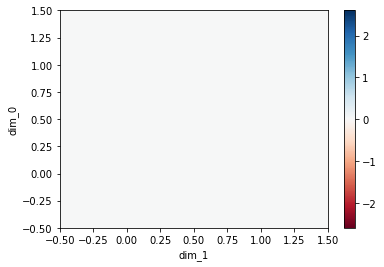

In [43]:
vmax = 2.6
cmap = 'RdBu'
xr.DataArray([[0,0],[0,0]]).plot.pcolormesh(vmin = -vmax, vmax = vmax, cmap = cmap)
plt.savefig(os.path.expanduser(f'~/Pictures/cbar{vmax}_{cmap}.pdf'))

In [46]:
pd.DataFrame(np.array([[460,460,100],[1.7,1.7,0.8],[0.025,0.025,0.015],[2,2,1]]),index = fields.index, columns = fields.columns)

npreds              3                  
slice  w_pacif_amplif                  
moment           init      obs     forc
z             460.000  460.000  100.000
sst             1.700    1.700    0.800
swvl13          0.025    0.025    0.015
t850            2.000    2.000    1.000

In [159]:
vmaxes

npreds              3                
slice  w_pacif_amplif                
moment           init     obs    forc
z              510.00  510.00  150.00
sst              2.20    2.20    1.20
swvl13           0.05    0.05    0.03
t850             2.60    2.60    1.00

SST is interesting. Although scale is different, probably the cold too zonally eastward extended? (Because the atmospheric pattern is wrong?). Soil moisture dipole seems persistent and corresponding to both initialization and and observation.

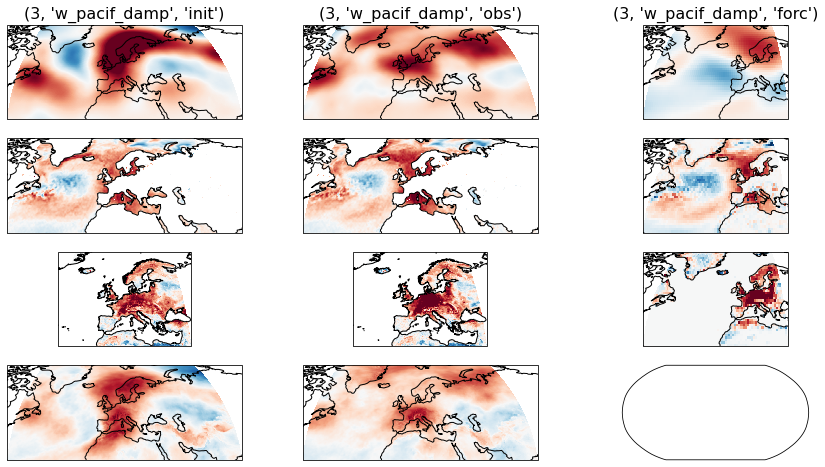

In [25]:
npreds = 3
slicename = 'w_pacif_damp'
fields = final.loc[:,(npreds,slicename,slice(None))]
vmaxes.columns = fields.columns
plotcomposites2(fields, vmaxes = vmaxes, coastlines=True)
plt.show()

Here the high pressure seems better placed. There is already atmospheric heat. Also sst good (there is already heat in the initialization and cold over the atlantic). Perhaps there is indeed less correction needed.

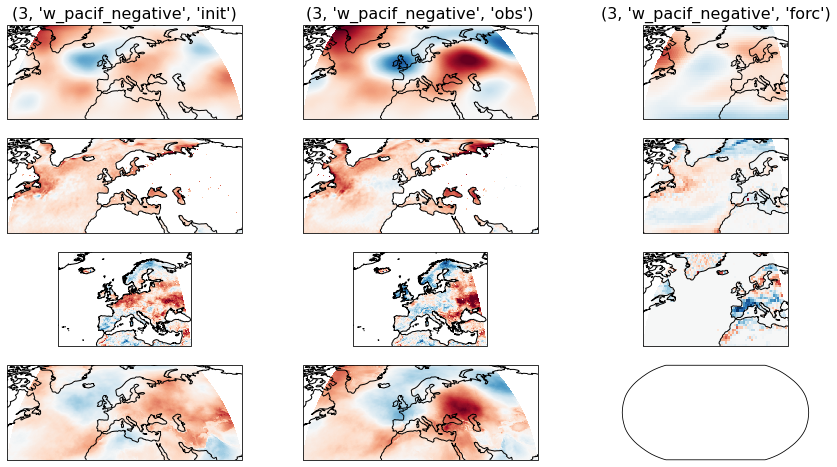

In [26]:
# These are more samples. Therefore unfair probably to use the same vmaxes.
npreds = 3
slicename = 'w_pacif_negative'
fields = final.loc[:,(npreds,slicename,slice(None))]
vmaxes = pd.DataFrame(np.array([[460,460,100],[1.7,1.7,0.8],[0.025,0.025,0.015],[2,2,1]]),index = fields.index, columns = fields.columns)
plotcomposites2(fields, vmaxes = vmaxes, coastlines=True)
plt.show()

Here swvl gets wetter during the two weeks of leadtime. Geopotential roughly right, pretty persistent from init to obs. Model has perhaps the low pressure not enough over great brittain (storm track pushed south). Model has this wettening too far south?

## Situation (local) as forecast by the model

In [19]:
# Over or under-estimation (of average temperature, not binarized yet)
#test = pd.read_hdf('/nobackup_1/users/straaten/match/paper3-1_tg-anom_JJA_45r1_31D-roll-mean_15-t2m-q095-adapted-mean_e39fc4cbb84c4f9ab1fa4b346eb9aa42.h5')
#test['separation'] = test['leadtime'] -1
#test = test.set_index(['time','clustid','separation']).sort_index().loc[(slice(None),9,slice(None)),:]
#test.index = test.index.droplevel('clustid')

In [9]:
npreds = 3
focus_class = -1
shap, _, outpos = get_data(npreds = npreds, std= False)
order = shap.index
p_cor = outpos['f_cor'].reindex(order)
forcs = pd.read_hdf('/nobackup/users/straaten/predsets/full/tg-anom_JJA_45r1_31D-roll-mean_q0.5_sep12-15_forc.h5').reindex(order)
obs = pd.read_hdf('/nobackup/users/straaten/predsets/full/tg-anom_JJA_45r1_31D-roll-mean_q0.5_sep12-15_obs.h5').reindex(order)
slices = get_slices(npreds = npreds)
for name, sl in slices.items():
    print(name, 'forc:',forcs.iloc[sl,focus_class].mean(), 'obs:', obs.iloc[sl,focus_class].mean(), 'p_cor', p_cor.iloc[sl].mean())

w_pacif_amplified forc: 0.53305614 obs: 0.95384616 p_cor 0.908829
w_pacif_dampened forc: 0.72260445 obs: 0.8 p_cor 0.84097075
w_pacif_negative forc: 0.52168036 obs: 0.1826087 p_cor 0.25446856


## Zoom on West-pacific sst pattern in initialization

In [27]:
clust = xr.open_dataset('/nobackup_1/users/straaten/clusters_cv_spearmanpar_varalpha_strict/sst_nhplus.21.corr.nc', decode_times = False)
clust = clust.sel(fold = 4, lag = -(15+21))
corrpattern = clust['correlation'].where(clust['clustid'] == 4, np.nan)


In [28]:
npreds = 3
patterns = final.loc['sst',(npreds,slice(None),'init')]
order = get_data(npreds = npreds, std= False)[0].index
preds = pd.read_hdf('/nobackup/users/straaten/predsets/full/tg-anom_JJA_45r1_31D-roll-mean_q0.5_sep12-15_predictors.h5').reindex(order)
slices = get_slices(npreds)

time        separation
2002-06-04  15            0.078643
2002-06-03  14            0.078643
2002-06-02  13            0.078643
2002-06-01  12            0.078643
2002-06-04  12            0.072432
                            ...   
2015-06-04  12            0.025826
            15            0.030186
2015-06-03  14            0.030186
2015-06-02  13            0.030186
2015-06-01  12            0.030186
Name: (sst_nhplus, 21, 4, spatcov), Length: 2272, dtype: float32

In [237]:
patterns.index

MultiIndex([(3,   'w_pacif_amplif', 'init'),
            (3,     'w_pacif_damp', 'init'),
            (3, 'w_pacif_negative', 'init')],
           names=['npreds', 'slice', 'moment'])

In [242]:
slices

{'w_pacif_amplif': slice(25, 155, None),
 'w_pacif_damp': slice(370, 480, None),
 'w_pacif_negative': slice(1250, 1710, None)}

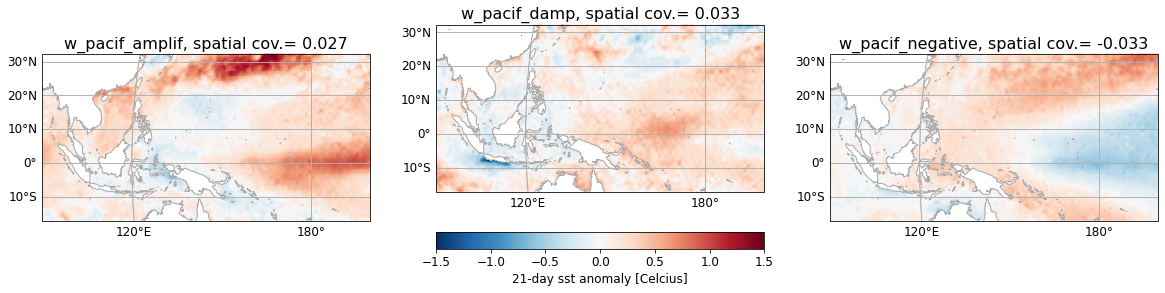

In [29]:
proj_crs = ccrs.Robinson(central_longitude=180)
fig, axes = plt.subplots(subplot_kw = {'projection':proj_crs}, ncols = len(patterns), squeeze = True, figsize = (20,5))

for i, key in enumerate(patterns.index):
    ax = axes[i]
    ax.set_extent((90,-160,-10,20))
    X, Y = np.meshgrid(corrpattern.longitude, corrpattern.latitude)
    #fill_c = ax.contourf(X, Y, corrpattern.values, levels = 20, transform = array_crs, 
    #           zorder = 0, vmin = -0.25, vmax = 0.25, cmap = 'PiYG_r')
    im = ax.pcolormesh(*data_for_pcolormesh(patterns.loc[key], shading = shading), zorder = 1, shading = shading, 
              transform = array_crs, cmap = 'RdBu_r',vmin = -1.5,vmax = 1.5)
    ax.coastlines(zorder = 2, lw = 1, color = 'darkgrey')

    #line_c = ax.contour(X, Y, corrpattern.values, levels = 20, transform = array_crs, 
    #           zorder = 2, vmin = -0.25, vmax = 0.25,  cmap = 'PiYG_r')

    sl = slices[key[1]]
    predictorval = np.round(preds.loc[:,('sst_nhplus',21,4,'spatcov')].iloc[sl].median(),3) # median value of the sst predictor in this composite.
    #ax.clabel(line_c,colors=['black'])
    ax.gridlines()
    gl = ax.gridlines(draw_labels=True)
    gl.top_labels = False
    gl.left_labels = True
    gl.right_labels = True
    ax.set_title(f'{key[1]}, spatial cov.= {str(predictorval)}', size = 16)
#fig.colorbar(fill_c, ax = axes[0], location = 'bottom', label = 'correlation')
fig.colorbar(im, ax = axes[1], location = 'bottom', label = '21-day sst anomaly [Celcius]')
#plt.savefig(os.path.expanduser('~/Pictures/westpacif_init.png'), dpi = 130)

This looks as ifthe middle configuration would see the largest input signal. The negative situation is indeed clear. Looks like a La nina situation?

### Snapshot of entire pacific.

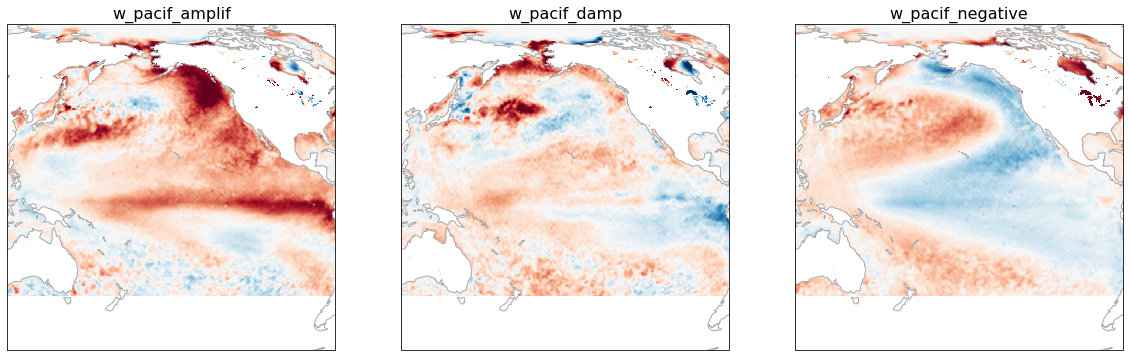

In [29]:
npreds = 3
patterns = final.loc['sst',(npreds,slice(None),'init')]
proj_crs = ccrs.Robinson(central_longitude=180)
fig, axes = plt.subplots(subplot_kw = {'projection':proj_crs}, ncols = len(patterns), squeeze = True, figsize = (20,9))

for i, key in enumerate(patterns.index):
    ax = axes[i]
    ax.set_extent((120,-80,-20,50))
    im = ax.pcolormesh(*data_for_pcolormesh(patterns.loc[key], shading = shading), zorder = 1, shading = shading, 
              transform = array_crs, cmap = 'RdBu_r',vmin = -1.5,vmax = 1.5)
    ax.coastlines(zorder = 2, lw = 1, color = 'darkgrey')
    
    sl = slices[key[1]]
    #ax.gridlines()
    ax.set_title(f'{key[1]}', size = 16)
#fig.colorbar(im, ax = axes[1], location = 'bottom', label = '21-day sst anomaly [Celcius]')

### Correspondence between input x gradient and shapley values.
Both in terms of the samples plot, and the interaction between xx and xx.

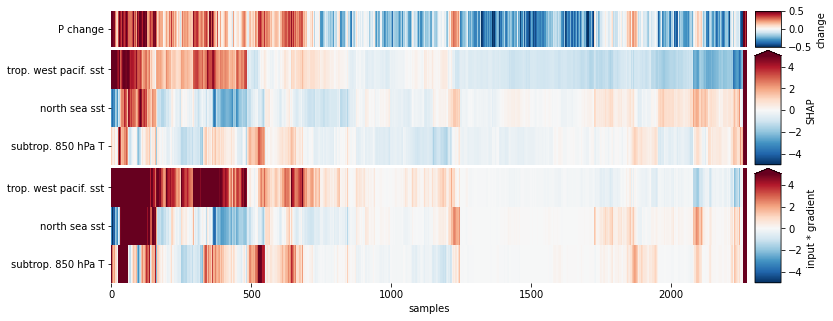

In [33]:
npreds = 3
slices = get_slices(npreds)
shap_sub, inpgrad_sub, outpos = get_data(npreds = npreds, std = True)
order_sub, _, _ = get_data(npreds = npreds, std = False)
nsamples = len(shap_sub.index)
order = order_sub.index
response = 'change'

fig = plt.figure(figsize=(12,5), facecolor = 'white')
gs1 = GridSpec(nrows = (npreds*2)+1, ncols = 20, hspace=0.1, wspace = 0.3)
ax_cor = fig.add_subplot(gs1[:1, :-1])
ax_shap = fig.add_subplot(gs1[1:(npreds+1), :-1])
ax_inpgr = fig.add_subplot(gs1[(npreds+1):, :-1])

ax_cbar_cor = fig.add_subplot(gs1[:1, -1:])
ax_cbar_shap = fig.add_subplot(gs1[1:(npreds+1), -1:])
ax_cbar_inpgr = fig.add_subplot(gs1[(npreds+1):, -1:])

cor = ax_cor.pcolor(outpos[[response]].reindex(order).T.values, vmin = -0.5, vmax = 0.5, cmap = 'RdBu_r')
ax_cor.set_yticks([0.5])
ax_cor.set_yticklabels([f'P {response}'])
ax_cor.xaxis.set_visible(False)

sh = ax_shap.pcolor(shap_sub.reindex(order).T.values, vmin = -5, vmax = 5, cmap = 'RdBu_r')
ax_shap.set_yticks(np.arange(0.5, len(shap_sub.columns)+0.5,1))
ax_shap.set_yticklabels(shap_sub.columns.to_flat_index().values)
ax_shap.xaxis.set_visible(False)

inpgr = ax_inpgr.pcolor(inpgrad_sub.reindex(order).T.values, vmin = -4, vmax = 4, cmap = 'RdBu_r')
ax_inpgr.set_yticks(np.arange(0.5, len(inpgrad_sub.columns)+0.5,1))
ax_inpgr.set_yticklabels(inpgrad_sub.columns.to_flat_index().values)
ax_inpgr.set_xlabel('samples')

fig.colorbar(cor, cax = ax_cbar_cor, label = response)
fig.colorbar(sh, cax = ax_cbar_shap, label = 'SHAP', extend = 'max')
fig.colorbar(sh, cax = ax_cbar_inpgr, label = 'input * gradient', extend = 'max')

for i in ax_expl.spines:
    ax_cor.spines[i].set_visible(False)
    ax_shap.spines[i].set_visible(False)
    ax_inpgr.spines[i].set_visible(False)

#expl_height = npreds + 0.1
#cor_height = 1.2
#color = 'black'
#alpha = 0.5
#ls = '--'
#for key, sl in slices.items():
#    ax_expl.vlines(x = max(sl.start,5), color = color, alpha = alpha, ymin = 0, linestyles = ls, ymax = expl_height)
#    ax_expl.vlines(x = min(sl.stop,nsamples - 3), color = color, alpha = alpha, ymin = 0, linestyles = ls, ymax = expl_height)
#    ax_cor.vlines(x = max(sl.start,5), color = color, alpha = alpha, ymin = -0.1, linestyles = ls, ymax = cor_height)
#    ax_cor.vlines(x = min(sl.stop,nsamples - 3), color = color, alpha = alpha, ymin = -0.1, linestyles = ls, ymax = cor_height)
#    ax_cor.hlines(y = cor_height, xmin = sl.start, xmax = sl.stop, color = color, alpha = alpha, linestyles = ls)
#    ax_cor.text(x = np.mean([sl.start,sl.stop]), y = cor_height + 0.1, s = key, color = color, alpha = 0.9, verticalalignment = 'bottom', horizontalalignment = 'center')

#ax_expl.set_ylim(bottom = 0, top = expl_height)
#ax_cor.set_ylim(bottom = -0.1)
plt.savefig(os.path.expanduser('~/Pictures/inpgrad_shap_corrspondence.pdf'))
plt.show()

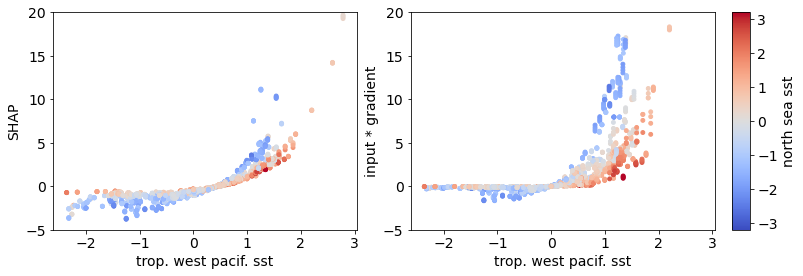

In [90]:
npreds = 3
slices = get_slices(npreds)
shap_sub, inpgrad_sub, outpos = get_data(npreds = npreds, std = True)

plt.rcParams['font.size'] = 14
fig = plt.figure(figsize=(12.5,4), facecolor = 'white')
gs1 = GridSpec(nrows = 1, ncols = 20, wspace = 1)

ax_shap = fig.add_subplot(gs1[0, :9])
ax_inpgr = fig.add_subplot(gs1[0, 10:19])
ax_cbar = fig.add_subplot(gs1[0,19:])

yvariable = 'trop. west pacif. sst'
interaction = outpos[('sst', 31, 1, 'mean')]
inp_values = outpos[('sst_nhplus', 21, 4, 'spatcov')]

ylim = (-5,20)
cmap = 'coolwarm'
s = 15
vmax = 3.2

ax_shap.scatter(x = inp_values, y = shap_sub[yvariable].reindex(inp_values.index), c = interaction, cmap = cmap, s = s, vmax = vmax, vmin = -vmax)
ax_shap.set_ylabel('SHAP')
ax_shap.set_ylim(ylim)
ax_shap.set_xlabel(yvariable)
im = ax_inpgr.scatter(x = inp_values, y = inpgrad_sub[yvariable].reindex(inp_values.index), c = interaction, cmap = cmap, s = s, vmax = vmax, vmin = -vmax)
ax_inpgr.set_ylabel('input * gradient')
ax_inpgr.set_ylim(ylim)
ax_inpgr.set_xlabel(yvariable)

fig.colorbar(im, cax = ax_cbar, label = 'north sea sst')
plt.savefig(os.path.expanduser('~/Pictures/inpgrad_shap_interaction.pdf'))

### Correspondance with other indices?
ENSO and 2 component RMM MJO

In [191]:
# Instantaneous values
rmm = pd.read_hdf('/nobackup/users/straaten/predsets/mjo_daily.h5').loc[:,(slice(None),slice(None),slice(None),['rmm1','rmm2'])]
nino = pd.read_hdf('/nobackup/users/straaten/predsets/nino_daily.h5')

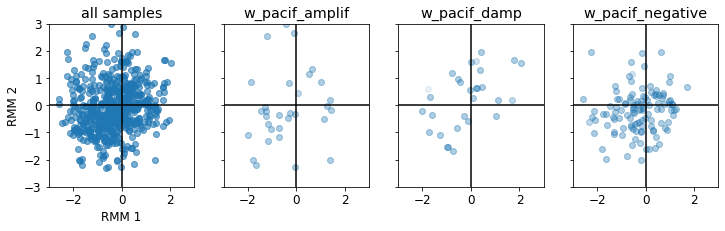

In [209]:
fig, axes = plt.subplots(ncols = 4, sharex = True, sharey = True, squeeze = False, figsize = (12,3))
# All points
ax = axes[0,0]
ax.set_ylim((-3,3))
ax.set_xlim((-3,3))
ax.hlines(0,-3,3, color = 'black')
ax.vlines(0,-3,3, color = 'black')
ax.scatter(x = rmm.loc[shap_sub.index,].iloc[:,0], y = rmm.loc[shap_sub.index,].iloc[:,1], alpha = 0.2)
ax.set_xlabel('RMM 1')
ax.set_ylabel('RMM 2')
ax.set_title('all samples')

npreds = 3
shap_sub, _, _ = get_data(npreds = npreds, std = False)
slices = get_slices(npreds = npreds)
for i, (key,sl) in enumerate(slices.items()):
    mjo_sub = rmm.loc[shap_sub.iloc[sl,:].index,:] # Can just select rmm directly.
    
    axes[0,i+1].scatter(x = mjo_sub.iloc[:,0], y = mjo_sub.iloc[:,1], alpha = 0.1)
    axes[0,i+1].set_title(key)
    axes[0,i+1].hlines(0,-3,3, color = 'black')
    axes[0,i+1].vlines(0,-3,3, color = 'black')

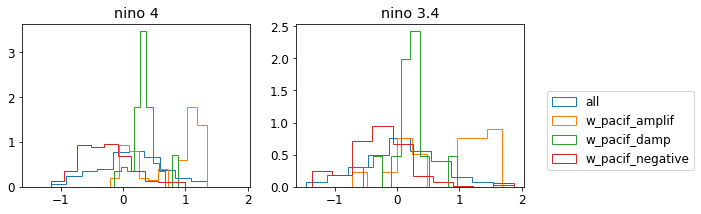

In [225]:
fig, ax = plt.subplots(ncols = 2, squeeze = False, sharex = True, figsize = (9,3))
ax[0,0].hist(nino.loc[shap_sub.index,(slice(None),1,4)], histtype = 'step', density = True)
ax[0,0].set_title('nino 4')
ax[0,1].hist(nino.loc[shap_sub.index,(slice(None),1,34)], histtype = 'step', label = 'all',density = True)
ax[0,1].set_title('nino 3.4')

npreds = 3
shap_sub, _, _ = get_data(npreds = npreds, std = False)
slices = get_slices(npreds = npreds)
for i, (key,sl) in enumerate(slices.items()):
    ax[0,0].hist(nino.loc[shap_sub.iloc[sl,].index,(slice(None),1,4)],histtype = 'step',density = True)
    ax[0,1].hist(nino.loc[shap_sub.iloc[sl,].index,(slice(None),1,34)], histtype = 'step',density = True,label = key)
ax[0,1].legend(loc=(1.1,0.1))

In [211]:
plt.hist()

variable                   nino          
timeagg                       1          
clustid                      34        4 
metric                     mean      mean
time       separation                    
1981-09-01 0          -0.033502 -0.087432
1981-09-02 0          -0.045651 -0.085928
           1          -0.033502 -0.087432
1981-09-03 0          -0.089331 -0.061235
           1          -0.045651 -0.085928
...                         ...       ...
2021-11-01 30         -0.444527 -0.535511
           31         -0.434131 -0.622799
2021-11-02 30         -0.489651 -0.484901
           31         -0.444527 -0.535511
2021-11-03 31         -0.489651 -0.484901

[468576 rows x 2 columns]